### Mat Watson's Car Collection Data Processing.

There were questions asked in one of my job applications regarding some SQL and data concepts. <br />Thought I'd play with their questions in code with GPT, using car data borrowed from an article about one of the eminent employee's car collection. 

- This repo will be made private repo in 6 months.
- You may have to install any missing packages by hand if you want to run locally.

#### List Questions about Mat Watson's car collection.

Answers will be displayed at the bottom of notebook.

In [101]:
question_bank = [

    "What insights can you derive from the data Mat?",
    "What is the most likely price of the next car in the collection?"
    "What do the cars say about about the person who owns the cars?",
    "Why did you buy the cars you did?",
    "Which car would be easiest to sleep in?",
    "Which car would hate the 'stick of truth' the most?"

] 

In [102]:
%%capture 
# /\ Remove to print cell output when debugging.

# Installations.
%pip install pandas; %pip install pandasql; %pip install scikit-learn; %pip install scipy; # Tries to installs packages 
%pip install IPython; %pip install graphviz; %pip install langchain                        # if not found on system.

## Note: You may have to install any missing packages by hand depending on your system setup.

In [103]:
# Imports
import pandas as pd;                  # Imports Pandas for dataframe management.
import pandasql as psql;              # Imports PandaSQL for querying pandas dataframes with SQL commands.
from langchain.llms import OpenAI     # Imports langchain for API to GPTs (only OpenAI and GPT-3 because I'm lazy).
import os                             # Imports os for easier processing of GPT-3 API keys in langchain.
from matplotlib import pyplot as plt  # Import pyplot to help visualise trees.
# Imports sklearn to train simple random forest model to visualise a few of its trees purposes.
from sklearn import tree, ensemble, preprocessing

### Data Aggregating.

Excel + PandaSQL dataframes will serve as our "database" for this example.

Mat Watson's car collection data obtained from: https://www.carhp.com/news/carwow-s-mat-watson-updated-2023-car-collection

Note, while I could throw together an AWS RDS for £0.02, throw the car collection data into it and make an *actual* SQL query via a Rest DB call, 
I want you to know I can't be arsed for that ¯_(ツ)_/¯ when the alternative takes 2 seconds and gets the same point across.

In [104]:
# Read and display Mat Watson car collection data from excel sheet. 
mats_car_collection = pd.read_excel('mats_car_collection_data.xlsx'); print(mats_car_collection.to_string()) 

      make         model  year decade  price  top_speed
0     Fiat           126  1980    80s   2500      100.0
1    Mazda      MX-5 Mk1  1989    80s   5090        NaN
2     Audi           RS6  2004    00s  10000      174.0
3  Porsche   911 Carrera  2000    00s  15995      175.0
4   Suzuki         Jimny  2023    20s  19500       90.0
5   Toyota      GR Yaris  2023    20s  35500      142.0


#### GROUP BY & other SQL shenanigans

They were specifically asking about SQL proficiency so I'm using PandaSQL. I am aware this is inefficient.

In [105]:
# Group dataset by decades and average prices.
SQL_query = "SELECT decade, AVG(price) FROM mats_car_collection GROUP BY decade;"
grouped_price_by_decade = psql.sqldf(SQL_query, locals()); print(grouped_price_by_decade)

  decade  AVG(price)
0    00s     12997.5
1    20s     27500.0
2    80s      3795.0


#### Applying Random Forests Predictions.

Given the dataset size predictions are likely god awful but this exists to visualise the simple, human-readable trees.

In [106]:
# Quickly clean up data for model.

# One-hot encode string data and append to collection datafrane.
x1 = pd.get_dummies(mats_car_collection["make"], prefix="make", dtype=float) 
x2 = pd.get_dummies(mats_car_collection["model"], prefix="model", dtype=float)
x3 = pd.get_dummies(mats_car_collection["decade"], prefix="decade", dtype=float)
mats_car_collection = pd.concat([mats_car_collection, x1, x2, x3], axis = 1, join = "outer") # Append data to Dataframe.

# Handle missing value.
mats_car_collection["top_speed"] = mats_car_collection["top_speed"].fillna(mats_car_collection["top_speed"].mean())

# Remove irrelevant columns.
mats_car_collection.drop(["make", "model", "decade"], inplace=True, axis=1)

# Display clean dataframe.
display(mats_car_collection)

,year,price,top_speed,make_Audi,make_Fiat,make_Mazda,make_Porsche,make_Suzuki,make_Toyota,model_126,model_ 911 Carrera,model_GR Yaris,model_Jimny,model_MX-5 Mk1,model_RS6,decade_00s,decade_20s,decade_80s
0,1980,2500,100.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1989,5090,136.2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,2004,10000,174.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,2000,15995,175.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2023,19500,90.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5,2023,35500,142.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [107]:
# "Train" for price prediction.
X_train = mats_car_collection.drop(["price"], axis=1)                             # Data used to predict. 
Y_train = mats_car_collection["price"]                                            # Data to predict.
X_train["top_speed"] = X_train["top_speed"].fillna(X_train["top_speed"].mean())   # Handling missing value.
rand_forest = ensemble.RandomForestRegressor(); rand_forest.fit(X_train, Y_train) # Train model.

RandomForestRegressor()

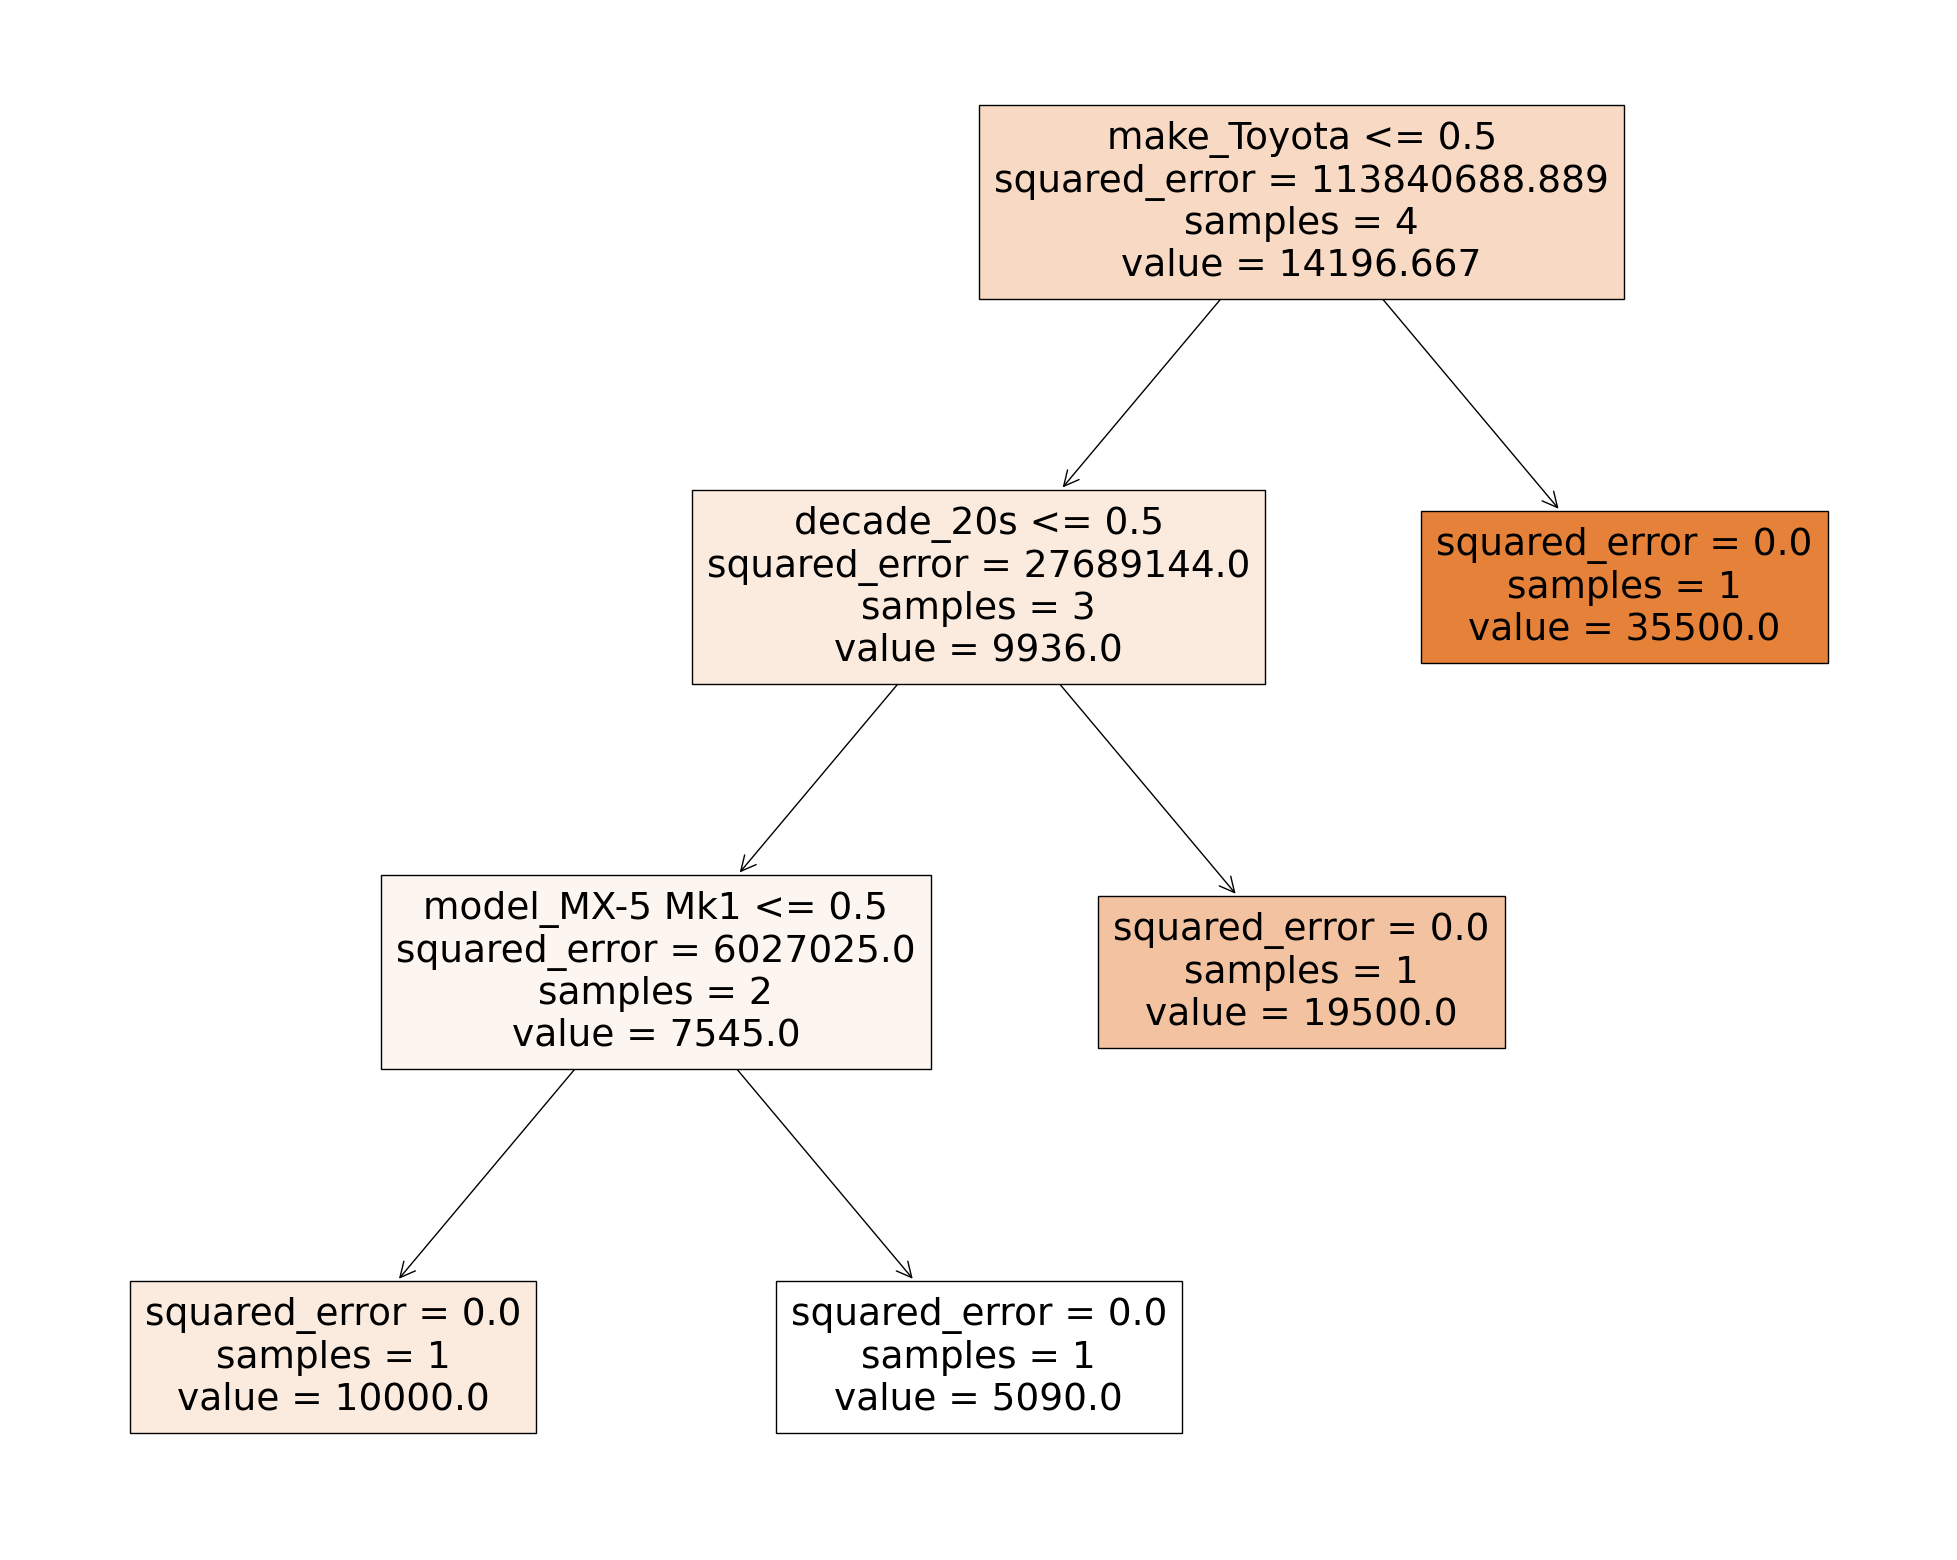

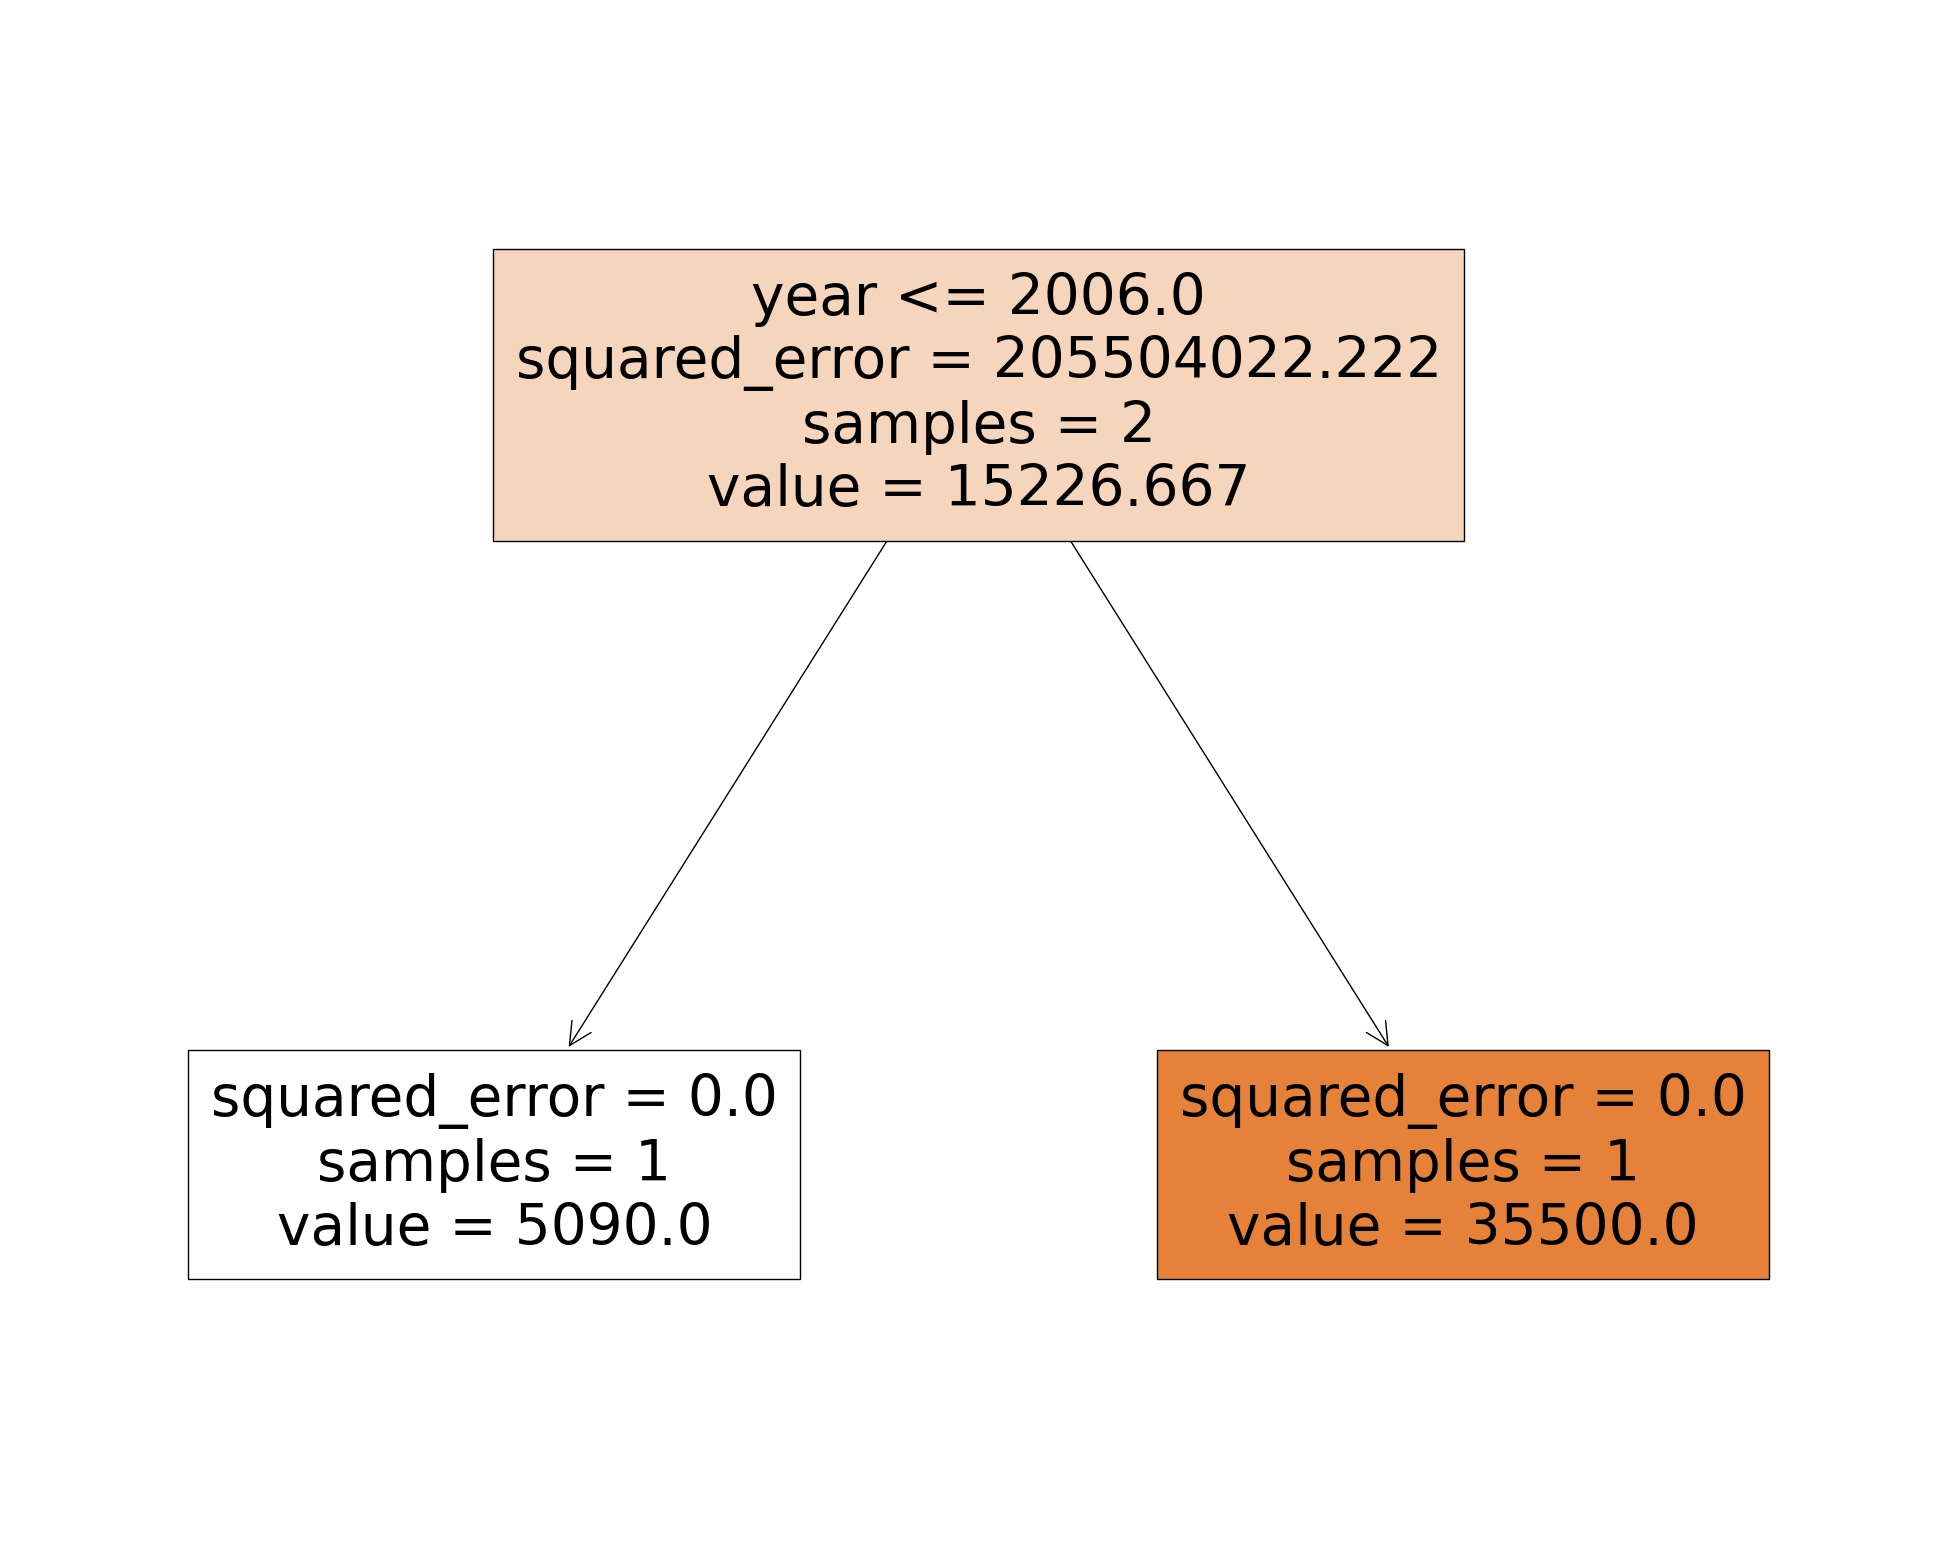

In [108]:
# Visualising first 2 decision trees in forest.
for i in range(2): fig = plt.figure(figsize=(25,20)); _ = tree.plot_tree(rand_forest.estimators_[i], # Draw plot.
                                                feature_names=X_train.columns,  
                                                class_names="target",
                                                filled=True)

### GPT-based Proccesing and Prediction
As this dataset is too small to provide any decent predictions based off of it alone, I thought I'd use GPT for analysis and prediction.<br/>
Thus, I'm performing car collection analysis based on Mat Watson's online personality data. This might end up terrible given its GPT-3, not GPT-4.

Maybe each user can have a personalized Mat Watso chatbot in the corner they can chat with regarding the listing they are looking at lol

### Limitations

OpenAI have automatic API key detection and disabling for public repos but don't still have a setting to adjust the sensitivity of that.

According to support, they are "working" on an non-key based authentication options. Timeframe = indefinite.


Thus, I made my own intergration; I separated the API key to block auto-detection and assigned a £1.50 API budget to prevent overly high spend. 

In [109]:
# API key selection.
os.environ["OPENAI_API_KEY"] = self_supplied_API_key = "<your_key_here>"        # <= Feel free to supply your own key.
keyA = ["VYnu39XZOZB", "kFJdSDjQ0FEahH", "sk-", "wxHqqWcHkT3Blb", "NLi2NKjhV"]  # £1.50 capped sample key.

# Prepare model for usage.
if len(self_supplied_API_key) != 54: os.environ["OPENAI_API_KEY"] = keyA[2] + keyA[0] + keyA[3] + keyA[1] + keyA[4] 
model = OpenAI(temperature=0.9) # Declare model connection and answer variation.

In [110]:
# Defining Mat Watson AI for repeated use.
def watson_reply(question):
    
    # Define prompt for API intake. 
    prompt = f"""
    You are the allegedly famous automotive journalist Mat Watson from Carwow. Speak as if you are him.

    Based on your experience as Mat Watson, your general knowledge and/or the datasets provided to you,
    please answer or explain your thoughts regarding: {question}

    Car Collection Data: {mats_car_collection}\n
    Grouped Car Data: {grouped_price_by_decade}\n
    """
     
    # Return AI Mat Watson response.
    return model(prompt) # PS: I am aware f-strings are quite unsafe due to injection issues; here they have no impact. 

# Maintains a uniform print style for all questions in loop.
def print_style(user_question, watson_answer):
    print(f"- Question:\n{user_question}\n- Answer:{watson_answer}\n\n-----\n") # Display formatted answer.

# Iterates through question array, processing and printing AI Watson replies for each one.
def watson_answer_compilation(question_bank):

    # Loop iterate through all questions, proceeses reply and prints it.
    for question in question_bank: watson_answer = watson_reply(question); print_style(question, watson_answer)

#### AI-Watson Answers Car Collection Queries.

Lets see how he handles it.

In [111]:
# Let AI-Watson answer queries list at top of notebook.
watson_answer_compilation(question_bank)

- Question:
What insights can you derive from the data Mat?
- Answer:
From these data sets, I'm seeing a few interesting trends about cars my audience may find interesting. First of all, the average price of a car across all decades is a lot higher in the 2000s and 2020s than it is in the 1980s. This could mean that cars have gotten more expensive over the years, or that people are buying more expensive cars as time goes on. 

I'm also seeing some trends regarding the types of cars people are buying. Audi, Porsche, and RS6 are popular among those wanting a high performance car. Mazda and Fiat are popular among those looking for more economical options. Finally, the Jimny, MX-5, and GR Yaris are popular among those wanting a more rugged, offroad style car. 

Overall, these data suggest that people are becoming more interested in higher performance, higher priced cars over time, but that there are still plenty of people interested in different types of cars with different price points.

